In [1]:
import subprocess

def get_gpu_info():
  """
  This function uses subprocess to execute nvidia-smi and capture the output.
  """
  nvidia_smi_output = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
  return nvidia_smi_output.stdout

# Get GPU information as a string
gpu_info_string = get_gpu_info()

# Print or process the GPU information string as needed
print(gpu_info_string)


Thu May 16 07:14:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX450         WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0             N/A / ERR!  |       0MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
import torch

# Set device to CPU
device = torch.device("cpu")

# Move your tensors to the CPU device
my_tensor = torch.randn(5, 5)  # Create a sample tensor
my_tensor = my_tensor.to(device)

# Your computations using my_tensor will now be done on CPU
# ... your code using my_tensor ...


OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\Manjula Sridhar\AppData\Roaming\Python\Python310\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [19]:
!pip install -q \                                                                      
autodistill \
autodistill_grounded_sam \

autodistill-yolov8 \
roboflow \
supervision==0.9.0

SyntaxError: invalid syntax (1216333791.py, line 3)

In [3]:
!pip install -q autodistill autodistill-grounded-sam autodistill-yolov8 roboflow supervision==0.9.0


^C


In [4]:
import os
HOME = os.getcwd()
print(HOME)

C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation


## 🖼️ Image dataset preperation

**NOTE:** To use Autodistill all you need to have is a folder of images that you want to automatically annotate, and use for target model training.

In [5]:
!mkdir "C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\images"

A subdirectory or file C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\images already exists.


In [6]:
#%mv {HOME}/<dataset-name>/train/* {HOME}/images

In [7]:
import shutil
import os

# Define dataset name (replace with your actual dataset name)
dataset_name = "solar_panel"

# Construct source and destination paths
source_path = r"C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\train"
destination_path = r"C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\images"

# Move files using shutil.move with error handling
try:
  for filename in os.listdir(source_path):
    shutil.move(os.path.join(source_path, filename), destination_path)
  print("Files moved successfully!")
except Exception as e:
  print(f"Error moving files: {e}")


Files moved successfully!


Now we are ready to start using Autodistill!

### Download raw videos

**NOTE:** In this tutorial, we will start with a directory containing video files and I will show you how to turn it into a ready-to-use collection of images. If you are working with your images, you can skip this part.

In [8]:
!mkdir videos
%cd "C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\videos"

# download zip file containing videos
#!wget https://media.roboflow.com/milk.zip

#unzip videos
#!unzip milk.zip

C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\videos


A subdirectory or file videos already exists.


### Convert videos into images

**NOTE:** Now, let's convert videos into images. By default, the code below saves every `10th` frame from each video. You can change this by manipulating the value of the `FRAME_STRIDE` parameter.

In [9]:
VIDEO_DIR_PATH = r"C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\videos"
IMAGE_DIR_PATH = r"C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\images"
FRAME_STRIDE = 10

In [27]:
!pip install supervision==0.9.0

Defaulting to user installation because normal site-packages is not writeable


**NOTE:** Notice that we put two of our videos aside so that we can use them at the end of the notebook to evaluate our model.

In [12]:
import supervision as sv
from tqdm.notebook import tqdm

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.jpg"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

0it [00:00, ?it/s]

### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [13]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpeg"])

print('image count:', len(image_paths))

image count: 208


**NOTE:** We can also plot sample of our image dataset.

In [14]:
IMAGE_DIR_PATH = r"C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

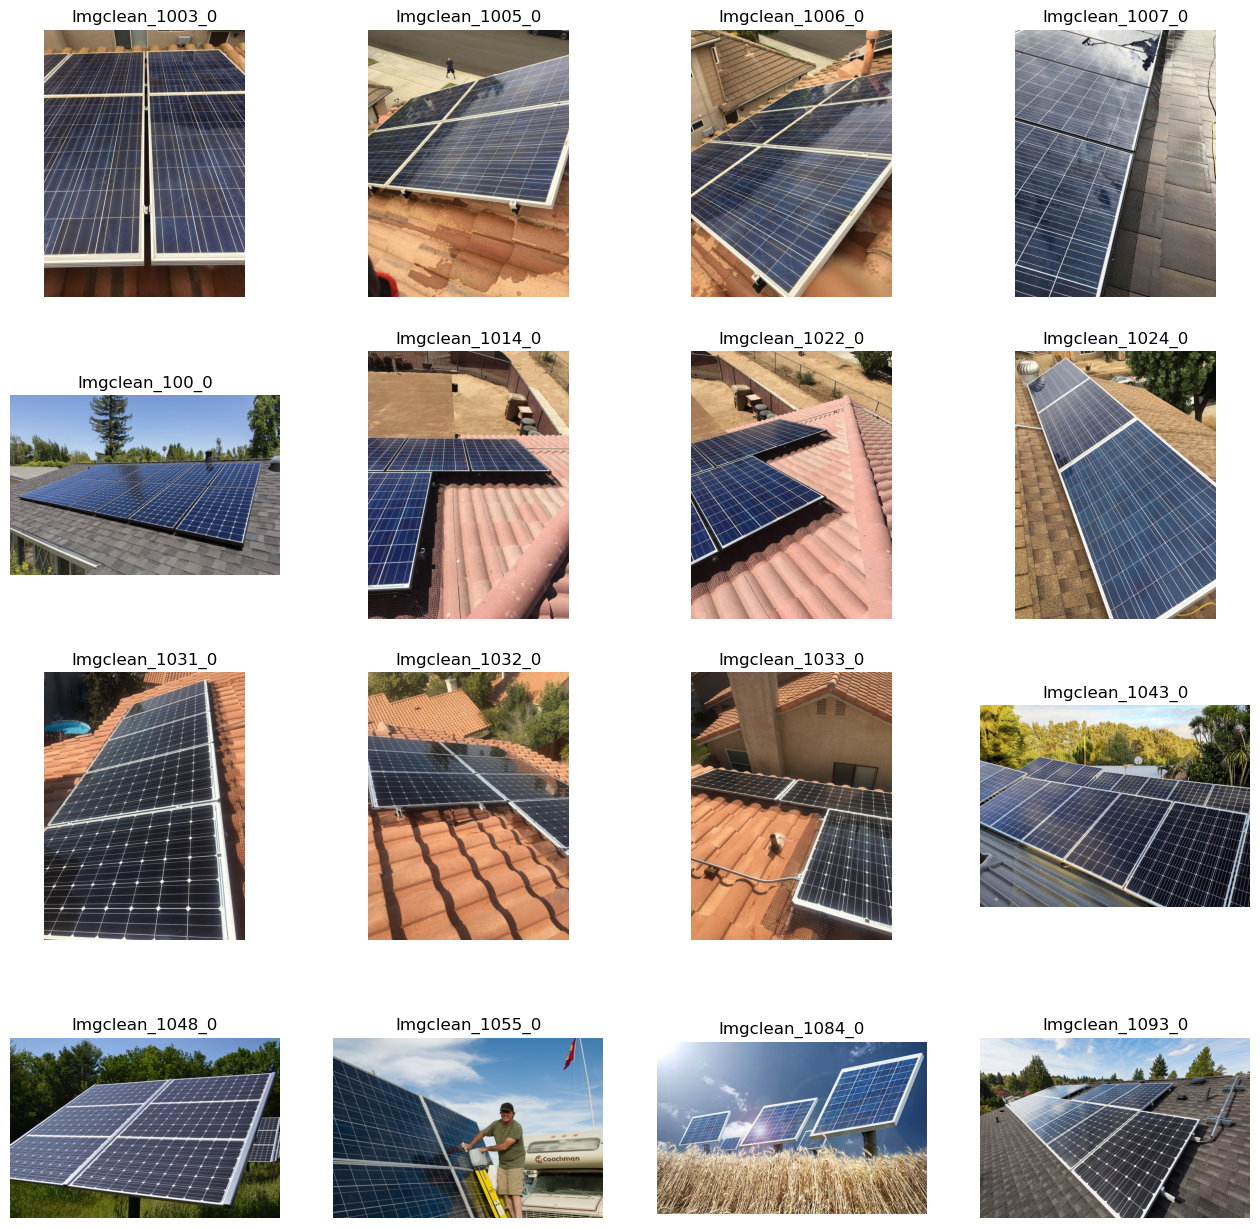

In [15]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ Autolabel dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [16]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "solar panel": "solar_panel",
    #"blue cap": "cap"
})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [17]:
DATASET_DIR_PATH = r"C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\dataset"

**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [20]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    #extensions=["png", "jpg", "jpeg"],
    
    output_folder=DATASET_DIR_PATH)

OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\Manjula Sridhar\AppData\Roaming\Python\Python310\site-packages\torch\lib\shm.dll" or one of its dependencies.

### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [ ]:
ANNOTATIONS_DIRECTORY_PATH = r"C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\dataset\train\labels"
IMAGES_DIRECTORY_PATH = r"C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\dataset\train\images"
DATA_YAML_PATH = r"C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\dataset\data.yaml"

In [ ]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

In [ ]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

## 🔥 Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [ ]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train(DATA_YAML_PATH, epochs=6)

In [ ]:
ls "C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\runs\detect\train2"

## ⚖️ Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=600)

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

## 🎬 Run Inference on a video

In [ ]:
INPUT_VIDEO_PATH = TEST_VIDEO_PATHS[0]
model = YOLOv8('yolov8n.pt')
OUTPUT_VIDEO_PATH = r"C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\videos\output\output.mp4"
TRAINED_MODEL_PATH = r"C:\Users\Manjula Sridhar\Desktop\Aditya\8th Sem\Auto annotation\runs\detect\train\weights\best.pt"

In [ ]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}
